In [1]:
import torch
import torchvision # torch for computer vision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # for reference later

Files already downloaded and verified
Files already downloaded and verified


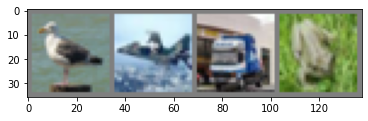

 bird plane truck  frog


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
labels

tensor([2, 0, 9, 6])

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [25]:
# move model to gpu
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# double check if the model is on cuda
next(net.parameters()).is_cuda 

True

# train

In [27]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # a mini-batch
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        if i == 1:
            print(outputs)
            print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


tensor([[-0.0247,  0.0743,  0.0963,  0.0381,  0.0286,  0.1127,  0.0083,  0.0763,
         -0.0734,  0.0018],
        [-0.0228,  0.0731,  0.0943,  0.0382,  0.0208,  0.1135,  0.0006,  0.0759,
         -0.0680,  0.0078],
        [-0.0379,  0.0661,  0.0917,  0.0398,  0.0239,  0.1105, -0.0083,  0.0795,
         -0.0823, -0.0016],
        [-0.0117,  0.0721,  0.0993,  0.0321,  0.0182,  0.1158,  0.0032,  0.0787,
         -0.0591,  0.0092]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([5, 0, 1, 2], device='cuda:0')
[1,  2000] loss: 2.255
[1,  4000] loss: 1.910
[1,  6000] loss: 1.711
[1,  8000] loss: 1.616
[1, 10000] loss: 1.550
[1, 12000] loss: 1.479
tensor([[-0.0310, -1.3121,  0.8531,  1.3368,  0.2567,  0.7800,  0.7779, -0.0293,
         -0.9285, -0.8121],
        [ 2.6199,  3.1986,  0.1835, -0.3198, -1.4520, -1.8943, -0.4908, -3.1391,
          2.0556,  0.8377],
        [-1.1087, -2.4164,  2.2214,  0.9982,  3.0089,  1.0273,  1.7990,  0.0265,
         -2.2875, -2.7568],
        [ 2.6450, 

In [15]:
# save model

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test

In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


Test on some examples:

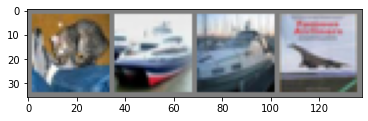

GroundTruth:  cat ship ship plane


In [38]:
# Show images from test
dataiter = iter(testloader)
images, labels = dataiter.next() # first batch

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(4)))

In [28]:
outputs = net(images.to(device)) # shape 4,10

In [31]:
prediction = torch.max(outputs, 1)[1]

In [32]:
prediction

tensor([3, 8, 8, 8], device='cuda:0')

In [37]:
print('Predicted: ', ' '.join(classes[prediction[j]]
                              for j in range(4)))

Predicted:  cat ship ship ship


## Error analysis

In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 39 %
Accuracy of   car : 74 %
Accuracy of  bird : 43 %
Accuracy of   cat : 40 %
Accuracy of  deer : 57 %
Accuracy of   dog : 43 %
Accuracy of  frog : 59 %
Accuracy of horse : 61 %
Accuracy of  ship : 82 %
Accuracy of truck : 54 %
